In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsdisagg import disaggregate_series
import statsmodels.api as sm

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names
def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 1950-01-01 to 2023-07-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bonds       147 non-null    float64
 1   Y           115 non-null    float64
 2   C           115 non-null    float64
 3   Kformation  115 non-null    float64
 4   stock       70 non-null     float64
 5   r           755 non-null    float64
 6   Exports     115 non-null    float64
 7   Imports     115 non-null    float64
dtypes: float64(8)
memory usage: 54.0 KB


,Bonds,Y,C,Kformation,stock,r,Exports,Imports
DATE,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,203497.859375,NaN,NaN,NaN
1951-01-01,NaN,NaN,NaN,NaN,206158.671875,NaN,NaN,NaN
1952-01-01,NaN,NaN,NaN,NaN,208901.093750,NaN,NaN,NaN
1953-01-01,NaN,NaN,NaN,NaN,214274.093750,NaN,NaN,NaN
1954-01-01,NaN,NaN,NaN,NaN,220242.234375,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-10-01,2.420667,5.719180e+11,2.528550e+11,1.385479e+11,NaN,1.25,3.607410e+11,3.201785e+11
2022-11-01,NaN,NaN,NaN,NaN,NaN,1.25,NaN,NaN
2023-01-01,2.509667,5.779868e+11,2.534612e+11,1.187667e+11,NaN,NaN,3.741787e+11,3.156046e+11


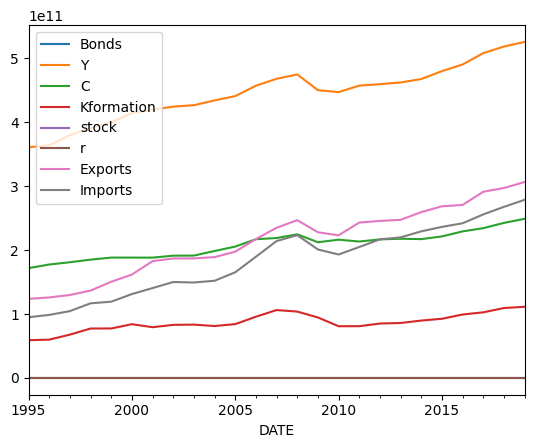

In [3]:
from pandas_datareader.fred import FredReader
fred_indicators = ['IRLTLT01DKQ156N', 'NAEXKP01DKQ189S', 'NAEXKP02DKQ189S', 'NAEXKP04DKQ189S', 'RKNANPDKA666NRUG', 'DNKLOCOSTORSTM', 'NAEXKP06DKQ652S', 'NAEXKP07DKQ652S']

df = FredReader(symbols=fred_indicators, start='1900-01-01', end=None, freq ='Q').read()

df.rename(columns={
    'IRLTLT01DKQ156N': 'Bonds', #monthly 
    'NAEXKP01DKQ189S': 'Y',
    'NAEXKP02DKQ189S': 'C',
    'NAEXKP04DKQ189S': 'Kformation',
    'RKNANPDKA666NRUG': 'stock', #annual
    'DNKLOCOSTORSTM': 'r', #monthly 
    'NAEXKP06DKQ652S': 'Exports',
    'NAEXKP07DKQ652S': 'Imports'
}, inplace=True)
df.to_csv('custom_df.csv')
df.dropna().plot()
df.info()
df

In [4]:
stock = df['stock']
#setting it up in years so it stops giving me missing values error since im going from low to higher frequency with stocks 
stock = df['stock'].resample('YS').last().dropna()
stock_quarterly = disaggregate_series(stock, target_freq='QS', agg_func='last')
r = df['r'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
r_decimal = r.mul(1 / 100)
r_quarterly = r_decimal.resample('QS').agg(compound_interest)
r_quarterly = r_quarterly + 1
r_quarterly
Br = df['Bonds'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
Br_decimal = Br.mul(1 / 100)
Br_quarterly = Br_decimal.resample('QS').agg(compound_interest)
Br_quarterly = Br_quarterly + 1
Br_quarterly

DATE
1987-01-01    1.114351
1987-04-01    1.111149
1987-07-01    1.111370
1987-10-01    1.114504
1988-01-01    1.102015
                ...   
2022-07-01    1.017203
2022-10-01    1.024207
2023-01-01    1.025097
2023-04-01    1.025690
2023-07-01    1.027630
Freq: QS-JAN, Name: Bonds, Length: 147, dtype: float64

In [5]:
df1 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/ANHRS/DNK.DE+TE.A/OECD?contentType=csv')
df1.to_csv('df1.csv')
df1 = df1[df1['Employment status'] == 'Total employment']
hours = df1.loc[:,['Time','Value']]
hours = hours.rename(columns= {'Value': 'N'})
hours['Time'] = pd.to_datetime(hours['Time'], format='%Y')
hours.set_index('Time', inplace=True)
quarterly_N = disaggregate_series(hours, target_freq='QS', agg_func='sum')
quarterly_N

1970-01-01    462.788670
1970-04-01    462.208044
1970-07-01    461.046792
1970-10-01    459.304914
1971-01-01    456.982409
                 ...    
2021-10-01    342.374966
2022-01-01    342.655797
2022-04-01    342.866420
2022-07-01    343.006836
2022-10-01    343.077043
Freq: QS-OCT, Name: N, Length: 212, dtype: float64

In [6]:
df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
df2.to_csv('df2.csv')
df2 = df2[df2['Subject'] == 'Manufacturing, Index']
wages = df2.loc[:,['Time','Value']]
wages = wages.rename(columns= {'Value': 'w'})
wages['Time'] = wages['Time'].apply(lambda x: x[3:] + "-" + "Q" + x[1])
wages['Time'] = pd.to_datetime(wages['Time'])
wages.set_index('Time', inplace=True)
wages.head()

C:\Users\Gaya\AppData\Local\Temp\ipykernel_13324\2957788866.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\Gaya\AppData\Local\Temp\ipykernel_13324\2957788866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\Gaya\AppData\Local\Temp\ipyker

,w
Time,
1971-01-01,6.801153
1971-04-01,7.283459
1971-07-01,7.472557
1971-10-01,7.702024
1972-01-01,7.810383


In [7]:
df_quarterly = pd.DataFrame()

In [8]:
df_quarterly['Br_quarterly'] = Br_quarterly
df_quarterly['r_quarterly'] = r_quarterly
df_quarterly['stock_quarterly'] = stock_quarterly
C = df['C']
df_quarterly['C_quarterly'] = C
Y = df['Y']
df_quarterly['Y_quarterly'] = Y
K = df['Kformation']
df_quarterly['K_quarterly'] = K
EX = df['Exports']
df_quarterly['EX_quarterly'] = EX
IM = df['Imports']
df_quarterly['IM_quarterly'] = IM
df_quarterly

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly
DATE,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11


In [9]:
merged = df_quarterly.join([quarterly_N, wages])
merged

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN,376.969796,36.85957
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN,374.055140,38.62382
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN,371.798882,38.72432
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN,370.201021,39.53945
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN,369.261557,39.55061
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11,343.006836,117.93010
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11,343.077043,118.15920
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11,NaN,118.84670


Br_quarterly


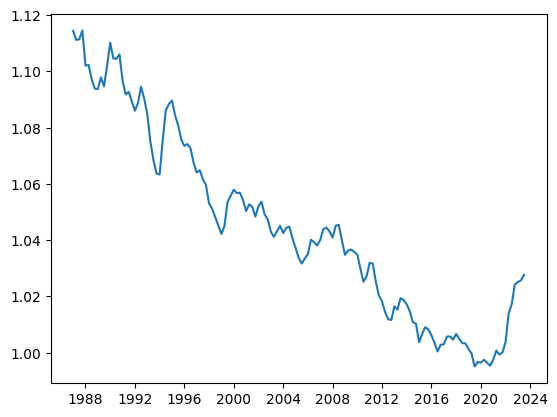

r_quarterly


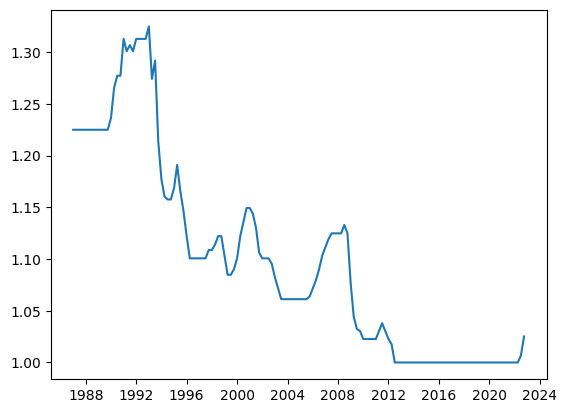

stock_quarterly


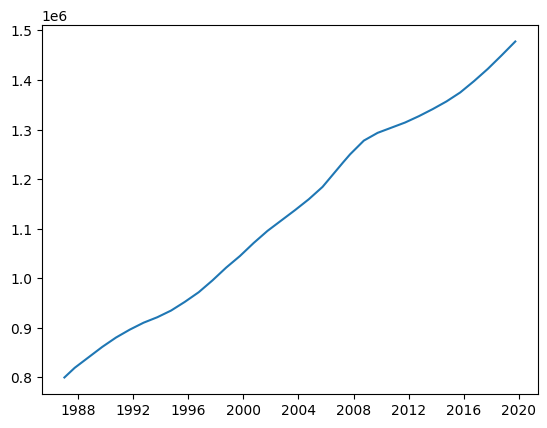

C_quarterly


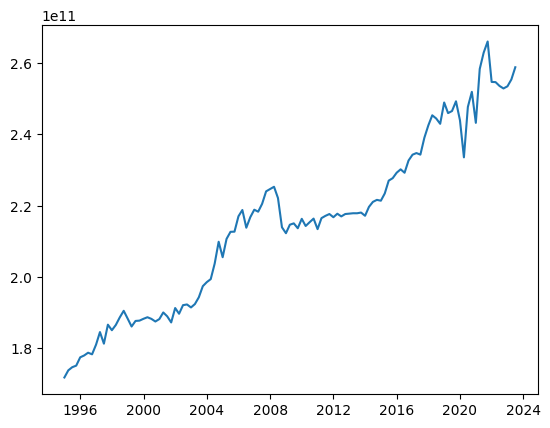

Y_quarterly


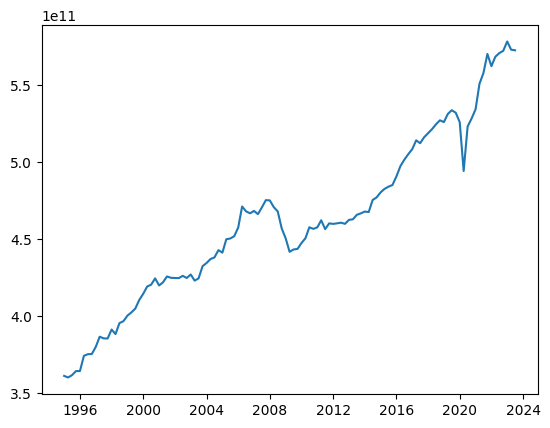

K_quarterly


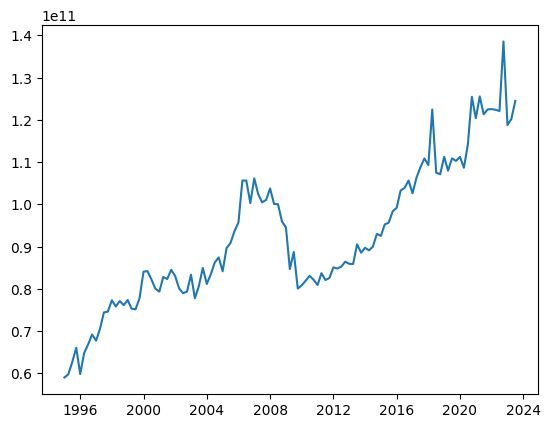

EX_quarterly


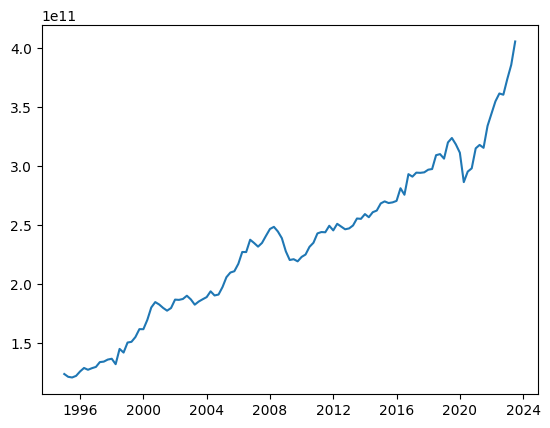

IM_quarterly


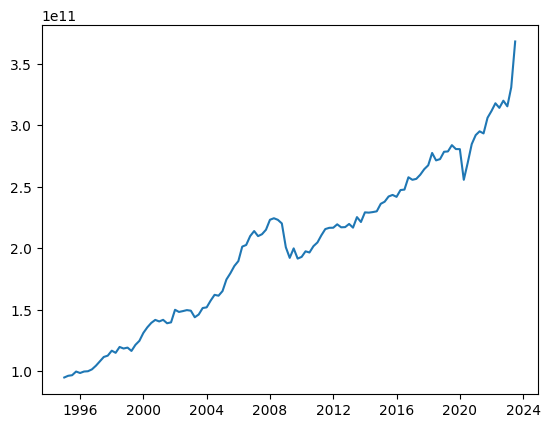

N


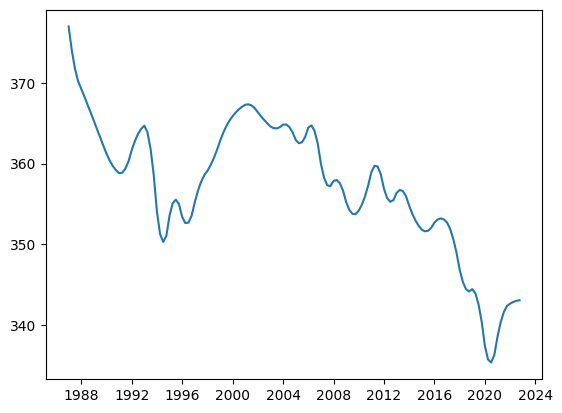

w


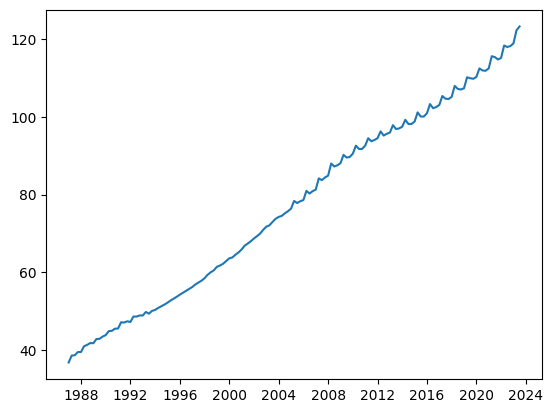

In [10]:
for columns in merged.columns:
    print(columns)
    column_data = merged[columns].dropna()
    plt.plot(column_data, label=columns)
    plt.show()

In [11]:
#Let's start with removing seasonality 
#Let's look at the list again and at what is not seasonally adjusted 
#'IRLTLT01DKQ156N': 'Bonds', #monthly --> not seasonally adjusted 
#NAEXKP01DKQ189S: Y,--> done
#'NAEXKP02DKQ189S': 'C',--> done 
#'NAEXKP04DKQ189S': 'Kformation',--> done 
#'RKNANPDKA666NRUG': 'stock', #annual, --> turned into stock_quarterly and not seasonally adjusted 
#'DNKLOCOSTORSTM': 'r', #monthly, turned into r_quarterly --> not seasonally adjusted 
#'NAEXKP06DKQ652S': 'Exports', --> done 
#'NAEXKP07DKQ652S': 'Imports'--> done 
#+ OECD variables are seasonally adjusted are per their description on the website 

<Axes: xlabel='DATE', ylabel='Resid'>

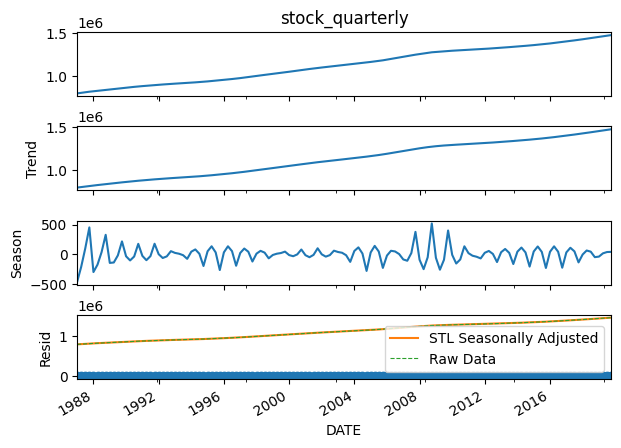

In [12]:
#Let's start with stock, aka investment 
stl_res= sm.tsa.STL(merged.stock_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['stock_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['stock_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

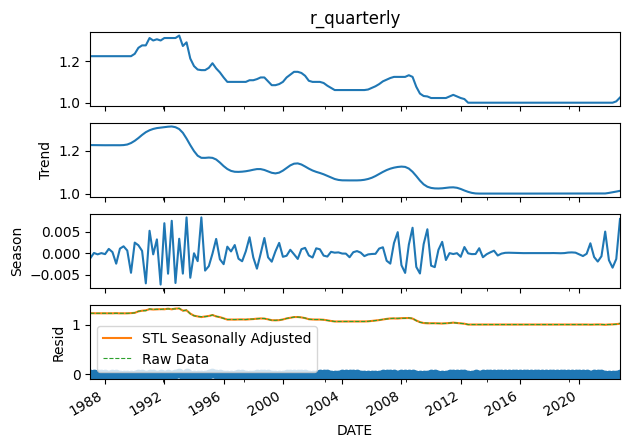

In [13]:
#now for r
stl_res= sm.tsa.STL(merged.r_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['r_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['r_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

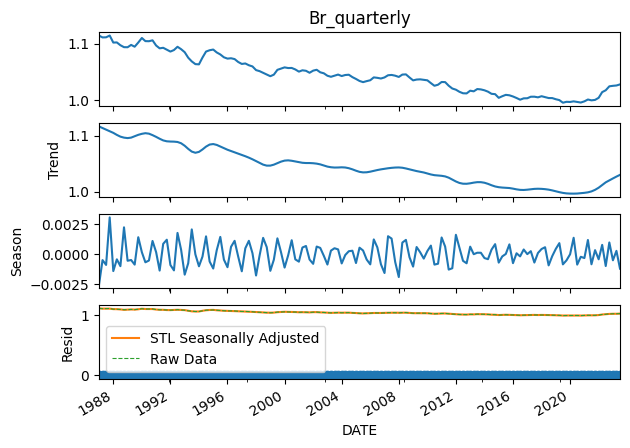

In [14]:
#finally, for bonds 
stl_res= sm.tsa.STL(merged.Br_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['Br_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['Br_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

In [15]:
#seasonal adjustment is done 
#moving on to de-trending 
#Let's start with everything but the rates 

<Axes: xlabel='DATE'>

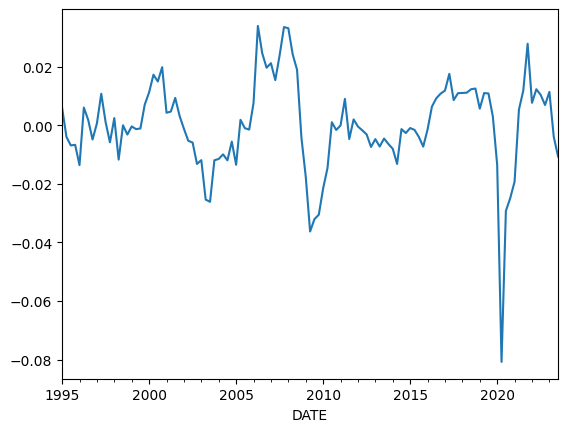

In [16]:
#starting with Y 
LogY = np.log(merged['Y_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogY)
Y = LogY = cycle
Y.plot()

<Axes: xlabel='DATE'>

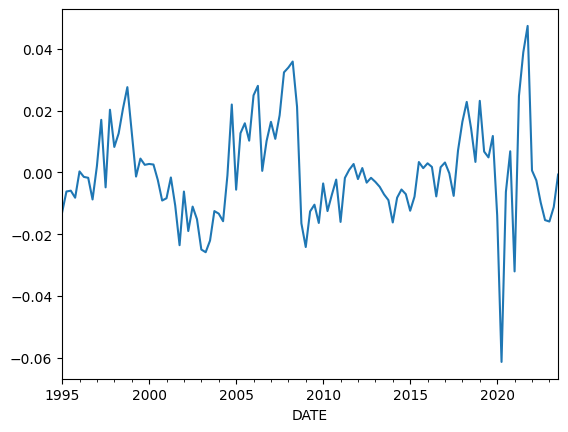

In [17]:
#now C  
LogC = np.log(merged['C_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogC)
C = LogC = cycle
C.plot()

<Axes: xlabel='DATE'>

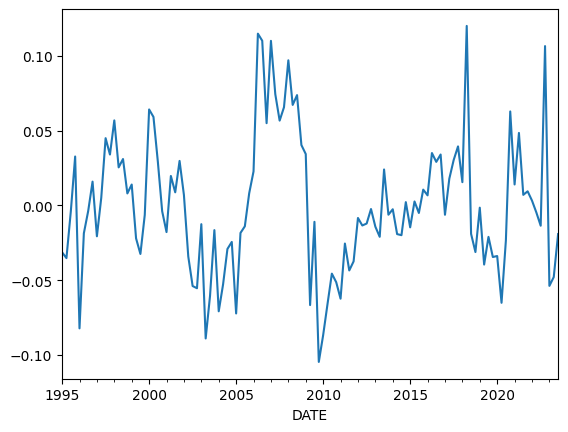

In [18]:
#now K
LogK = np.log(merged['K_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogK)
K = LogK = cycle
K.plot()

<Axes: xlabel='DATE'>

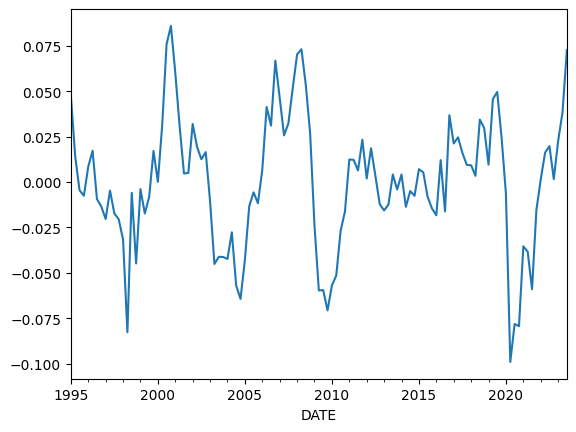

In [19]:
#now EXports  
LogEX = np.log(merged['EX_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogEX)
EX = LogEX = cycle
EX.plot()

<Axes: xlabel='DATE'>

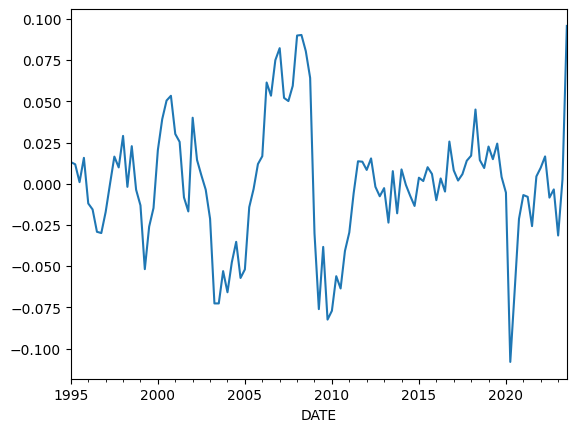

In [20]:
#now IM
LogIM = np.log(merged['IM_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogIM)
IM = LogIM = cycle
IM.plot()

In [21]:
#de-trending rates:
merged['r_quarterly'] = merged['r_quarterly'] - merged['r_quarterly'].mean()
merged['Br_quarterly'] = merged['Br_quarterly'] - merged['Br_quarterly'].mean()

<Axes: xlabel='DATE'>

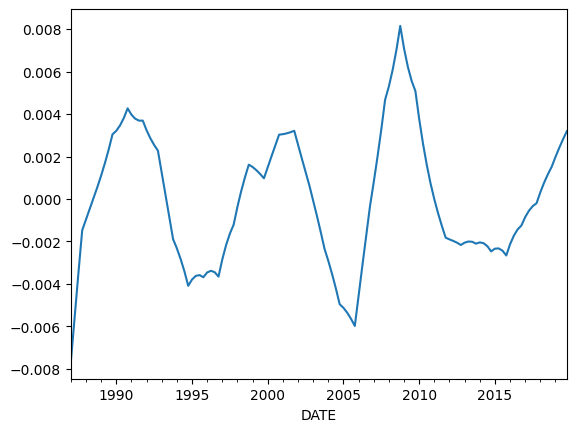

In [22]:
merged['stock_quarterly'] = merged['stock_quarterly'].dropna()
LogI= np.log(merged['stock_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogI)
I = LogI = cycle
I.plot()

<Axes: xlabel='DATE'>

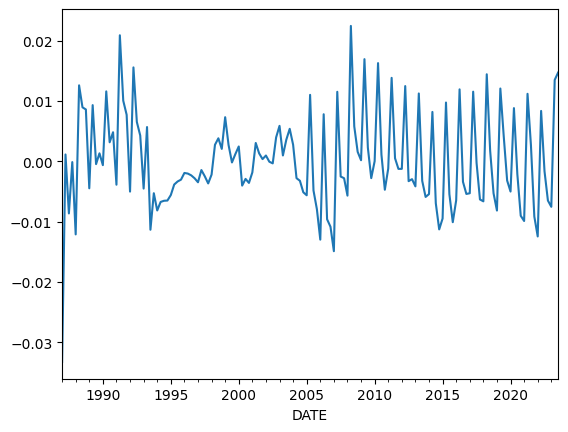

In [23]:
Logw= np.log(merged['w'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(Logw)
w = Logw = cycle
w.plot()

<Axes: xlabel='DATE'>

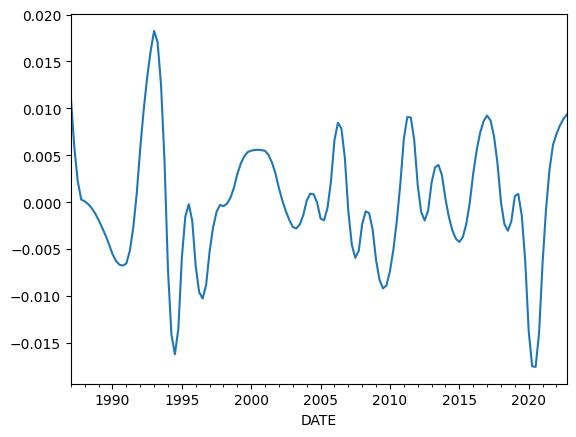

In [24]:
LogN= np.log(merged['N'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogN)
N = LogN = cycle
N.plot()

In [25]:
#now make the trade balance variables 
TB = EX - IM
TB_to_Y = TB / Y
merged ['TB_to_Y'] = TB_to_Y

In [26]:
processed = pd.DataFrame()
processed['Y'] = Y
processed['C'] = C
processed['I'] = I
processed['K'] = K
processed['TB_to_Y'] = merged['TB_to_Y']
processed['N'] = N
processed['r'] = merged['r_quarterly']
processed['w'] = w
processed['R'] = merged['Br_quarterly']
processed

,Y,C,I,K,TB_to_Y,N,r,w,R
DATE,,,,,,,,,
1995-01-01,0.005957,-0.012950,-0.003790,-0.031336,5.792201,-0.005960,0.069141,-0.005589,0.044672
1995-04-01,-0.003976,-0.006173,-0.003619,-0.035218,-0.614913,-0.001552,0.091507,-0.003846,0.039509
1995-07-01,-0.006886,-0.005907,-0.003582,-0.004120,0.806642,-0.000232,0.066385,-0.003340,0.035949
1995-10-01,-0.006673,-0.008181,-0.003683,0.032705,3.484018,-0.001993,0.047111,-0.003035,0.030902
1996-01-01,-0.013601,0.000323,-0.003458,-0.082173,-1.502679,-0.006849,0.022651,-0.001928,0.028562
...,...,...,...,...,...,...,...,...,...
2022-07-01,0.010363,-0.009722,NaN,-0.013567,2.720799,0.008851,-0.093009,-0.001638,-0.027725
2022-10-01,0.006912,-0.015422,NaN,0.106507,0.729223,0.009334,-0.074352,-0.006497,-0.020721
2023-01-01,0.011385,-0.015883,NaN,-0.053775,4.746176,NaN,NaN,-0.007536,-0.019831


(105, 9)
(105, 9)
Y


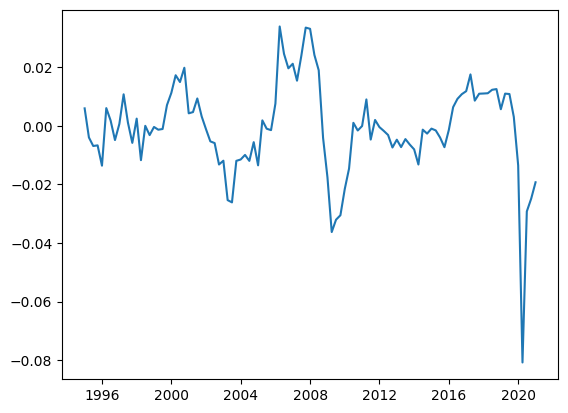

C


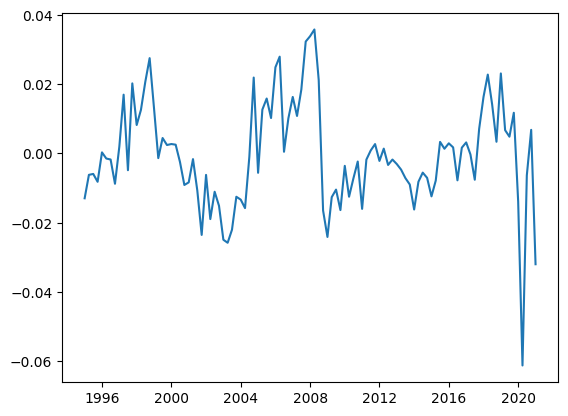

I


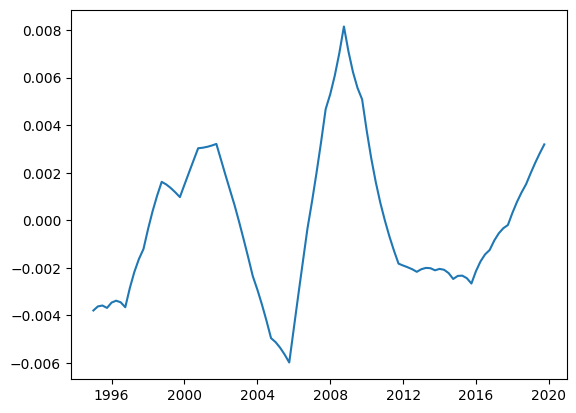

K


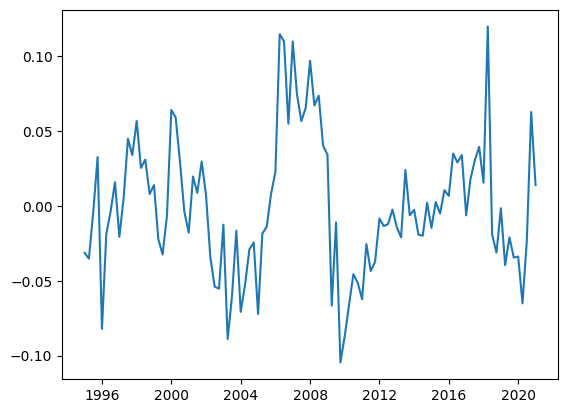

TB_to_Y


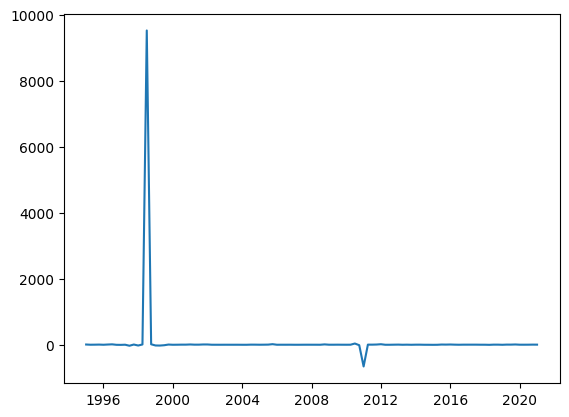

N


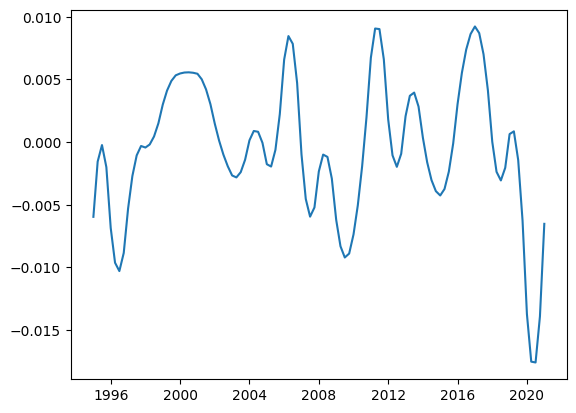

r


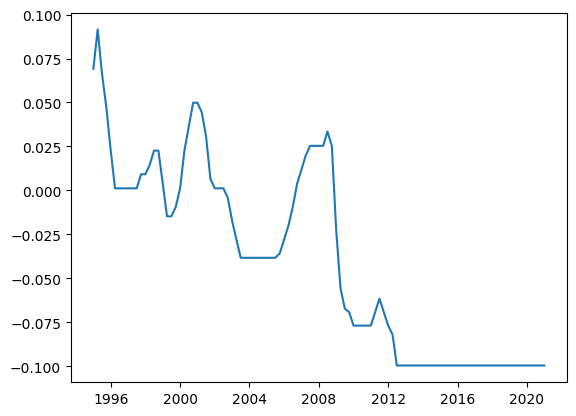

w


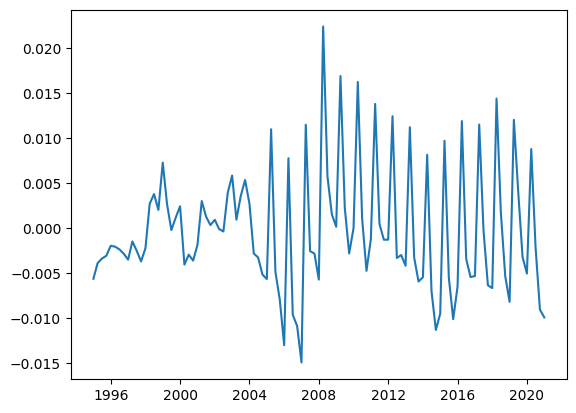

R


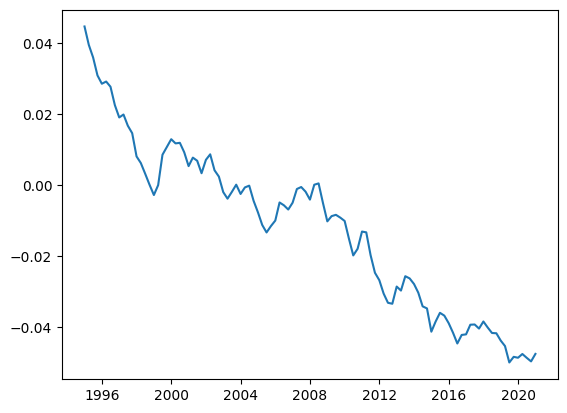

In [44]:
#train/split
n_test=10
processed_train = processed.iloc[:-n_test, :].copy()
processed_test= processed.iloc[:-n_test, :].copy()
print(processed_train.shape)
print(processed_test.shape)
for columns in processed_train.columns:
    print(columns)
    columntrain_data = processed_train[columns].dropna()
    plt.plot(columntrain_data, label=columns)
    plt.show()

In [42]:
ADF_test_summary(processed_train, missing = 'drop') #why is it not showing me all the variables 

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.261         -3.856        0.014          0    -4.049      -3.454     -3.152
	Constant             0.000          0.211        0.834
	Trend               -0.000         -0.453        0.652
Constant Only               -0.259         -3.849        0.002          0    -3.495      -2.890     -2.582
	Constant            -0.000         -0.369        0.713
No Constant                 -0.258         -3.854        0.000          0    -2.588      -1.944     -1.614
                                                      C                                                       
Specification               Coeff          Statistic     P-value      La